### Here we build a ann that can beat RF in adult dataset which has mainly tabular data in it.

In [15]:
import numpy as np
import pandas as pd

from fastai.tabular.all import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

path = untar_data(URLs.ADULT_SAMPLE)

df = pd.read_csv(path/'adult.csv')
sel_obj = make_column_selector(dtype_include=[object, 'category'])
sel_cont = make_column_selector(dtype_include=np.number)

df.loc[:, sel_obj(df)] = df.loc[:, sel_obj(df)].astype('category') 

# Fillnans
df.fillna(method='bfill', inplace=True)

# There are additional spaces everyeher..
for c in sel_obj(df):
    df.loc[:, c] = df.loc[:, c].map(lambda s: s.strip())


ord_dict = np.load(path/'cat_feature_order_dict.npy', allow_pickle=True).item()
for key in ord_dict.keys():
    feat_order = ord_dict[key].items()
    cats = np.array(sorted(feat_order, key=lambda t: t[1]))[:, 0]
    df.loc[:, key].cat.set_categories(cats, ordered=True, inplace=True)

# Transformers
nn_cat_pipe = Pipeline([('ordinal', OrdinalEncoder()), ('std', StandardScaler())])
ct = ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(), sel_obj)], remainder='passthrough')
ct_nn = ColumnTransformer(transformers=[('ordinal+std', nn_cat_pipe, sel_obj), 
                                        ('standard', StandardScaler(), sel_cont)], 
                          remainder='passthrough')

# Train test split
y = df.loc[:, 'salary']
df = df.drop(columns='salary')
X_train, X_valid, y_train, y_valid  = train_test_split(df, y)

X_train_enc = ct.fit_transform(X_train)
X_valid_enc = ct.transform(X_valid)
X_train_nn = ct_nn.fit_transform(X_train)
X_valid_nn = ct_nn.transform(X_valid)

train_idxs = X_train.index.values
valid_idxs = X_valid.index.values


In [3]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df, procs=procs_nn, 
                      cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                      cont_names = ['age', 'fnlwgt', 'education-num'],
                      y_names="salary",
                      splits=(list(train_idxs), list(valid_idxs)))

dls = to_nn.dataloaders(24)
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,age,fnlwgt,education-num,salary
0,Self-emp-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,51.000000,231230.000104,13.0,<50k
1,Private,Bachelors,Never-married,Prof-specialty,Not-in-family,White,25.000000,123082.997837,13.0,<50k
2,Private,Masters,Never-married,Prof-specialty,Not-in-family,White,49.000000,43348.002142,14.0,>=50k
3,Federal-gov,Assoc-acdm,Separated,Prof-specialty,Not-in-family,White,64.000000,267545.998704,12.0,>=50k
4,Federal-gov,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,51.000000,306783.997433,9.0,>=50k
5,Private,Some-college,Never-married,Sales,Not-in-family,White,27.000000,249315.000084,10.0,<50k
6,State-gov,HS-grad,Married-civ-spouse,Protective-serv,Husband,White,68.999999,34339.000180,9.0,<50k
7,Private,12th,Never-married,Handlers-cleaners,Own-child,White,17.000000,226716.999482,8.0,<50k
8,Private,HS-grad,Divorced,Machine-op-inspct,Not-in-family,White,24.000000,433330.007881,9.0,<50k
9,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,26.000000,137795.000465,13.0,<50k


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0063095735386013985)

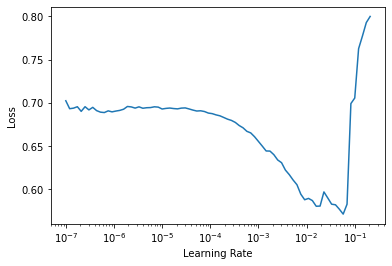

In [22]:
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find()


In [25]:
learn.fit_one_cycle(5, lr=.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.320282,0.368062,0.830979,00:07
1,0.365679,0.369761,0.829382,00:07
2,0.332363,0.362669,0.831593,00:07
3,0.348116,0.364918,0.832453,00:06
4,0.339654,0.360971,0.832576,00:07


In [36]:
from sklearn.metrics import accuracy_score, classification_report
rf = RandomForestClassifier(n_estimators=200, oob_score=True)
rf.fit(X_train_enc, y_train)

y_pred = rf.predict(X_valid_enc)

print(classification_report(y_valid, y_pred, digits=4))

              precision    recall  f1-score   support

        <50k     0.8918    0.9330    0.9119      6177
       >=50k     0.7534    0.6441    0.6945      1964

    accuracy                         0.8633      8141
   macro avg     0.8226    0.7885    0.8032      8141
weighted avg     0.8584    0.8633    0.8595      8141



In [40]:
is_valid = np.zeros(len(df), dtype=bool)
is_valid[valid_idxs] = True

df_enc = ct.fit_transform(df)

rf.fit(df_enc, is_valid)
print(rf.oob_score_)
y_pred = rf.predict(df_enc)
print(classification_report(is_valid, y_pred, digits=4))

0.7345904609809281
              precision    recall  f1-score   support

       False     0.9997    1.0000    0.9998     24420
        True     0.9999    0.9991    0.9995      8141

    accuracy                         0.9998     32561
   macro avg     0.9998    0.9995    0.9997     32561
weighted avg     0.9998    0.9998    0.9998     32561



In [45]:
y_pred =  np.where(is_valid, rf.oob_decision_function_[:, 0], rf.oob_decision_function_[:, 1]) > .5
print(classification_report(is_valid, y_pred, digits=4))

              precision    recall  f1-score   support

       False     0.9876    0.9683    0.9779     24420
        True     0.9102    0.9635    0.9361      8141

    accuracy                         0.9671     32561
   macro avg     0.9489    0.9659    0.9570     32561
weighted avg     0.9682    0.9671    0.9674     32561



In [59]:
sorted(zip(df.columns, rf.feature_importances_), key=lambda t: t[1], reverse=True)

[('sex', 0.28733066759531356),
 ('race', 0.18779723212953295),
 ('native-country', 0.11423546682700926),
 ('education', 0.09368343414284039),
 ('age', 0.04814547068853805),
 ('capital-gain', 0.04319401481359567),
 ('education-num', 0.04250291822084679),
 ('workclass', 0.042064087415118245),
 ('fnlwgt', 0.03506345060412116),
 ('relationship', 0.024870882182178474),
 ('capital-loss', 0.02372038718639654),
 ('marital-status', 0.023670051205125452),
 ('occupation', 0.01849007572831551),
 ('hours-per-week', 0.015231861261068003)]